## Importing libraries and modules static variables

In [1]:
import torch
import vars.model_run as mod

from vars.utilities import *
from torchvision import transforms


## Initilizing static variables

In [19]:
PATH = "./Data/Chess/"
CSV_PATH =  "./Data/"
CHECK_PATH = "./lightning_logs/version_1/checkpoints/epoch=5-step=204.ckpt"
BATCH = 20
RATIO = [0.6,0.2,0.2]
EPOCH = 50
LR = 0.001

transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

## Initilizing a model

In [20]:
model = mod.model_run(data_directory=PATH, transformer=transform, batch_size=BATCH, ratio=RATIO, epoch=EPOCH, learning_rate=LR)


## Using the model for Data loading and Data setups

Splited data :
                  tain sample number:667
                  validation sample number:222
                  test sample number:222


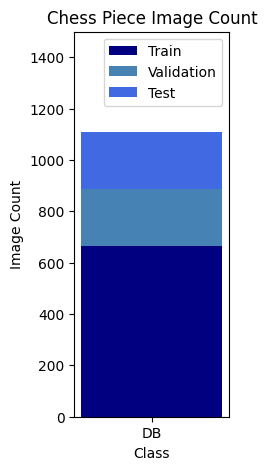

In [21]:
model.setup_data()

## Pre Processing Units (Attention: Run only with unnormalized or if collected your own dataset.)

```python
pre_process(model.data.dir_list)
create_CSV(dir=PATH, out_dir=CSV_PATH)
```

***Attention : it might delete existing photos!***

In [ ]:
"""
pre_process(model.data.dir_list)
create_CSV(dir=PATH, out_dir=CSV_PATH)
"""

## Checking if data has been Successfully loaded

In [22]:
model.data.labels

['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

In [23]:
model.data.dir_list

['./Data/Chess/Bishop',
 './Data/Chess/King',
 './Data/Chess/Knight',
 './Data/Chess/Pawn',
 './Data/Chess/Queen',
 './Data/Chess/Rook']

<Figure size 1000x400 with 0 Axes>

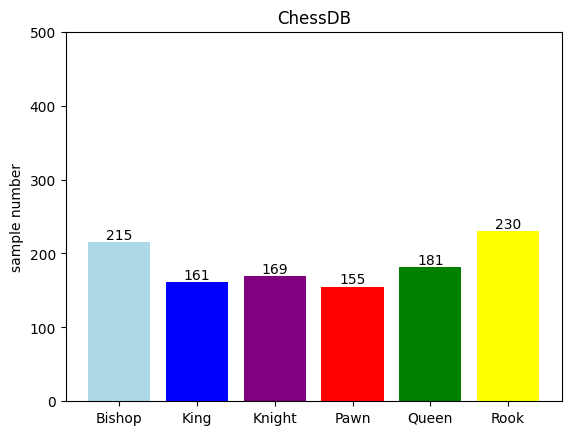

In [24]:
plot_bar(dir=PATH, labels=model.data.labels)

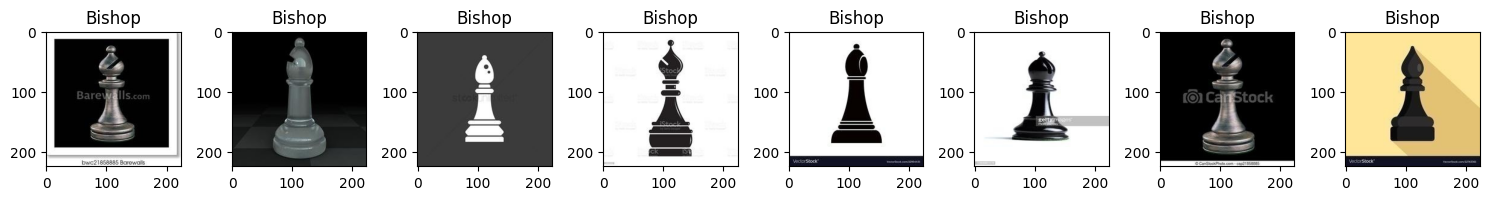

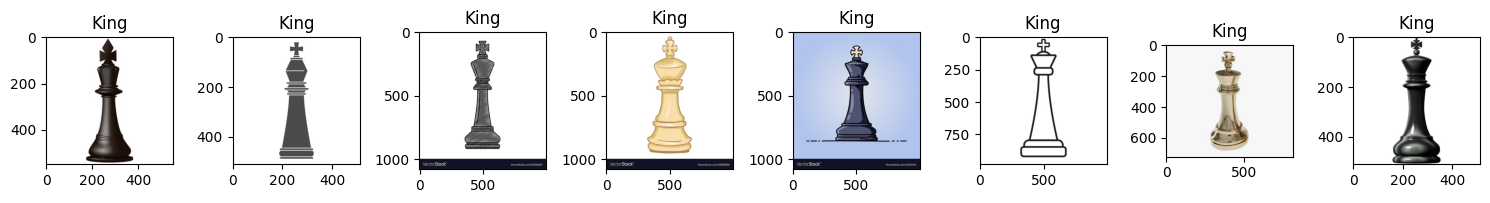

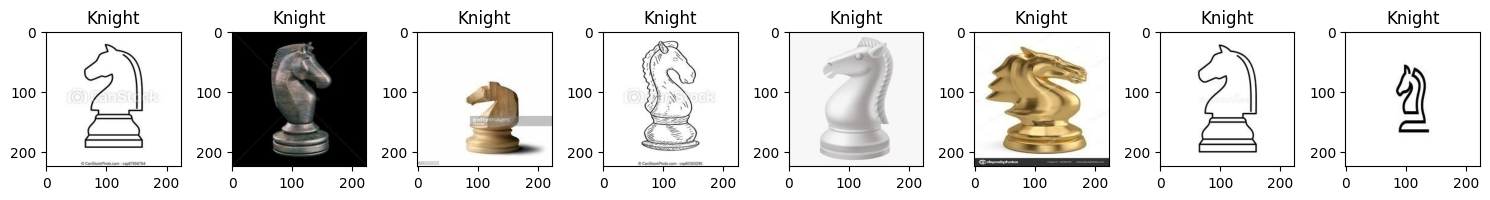

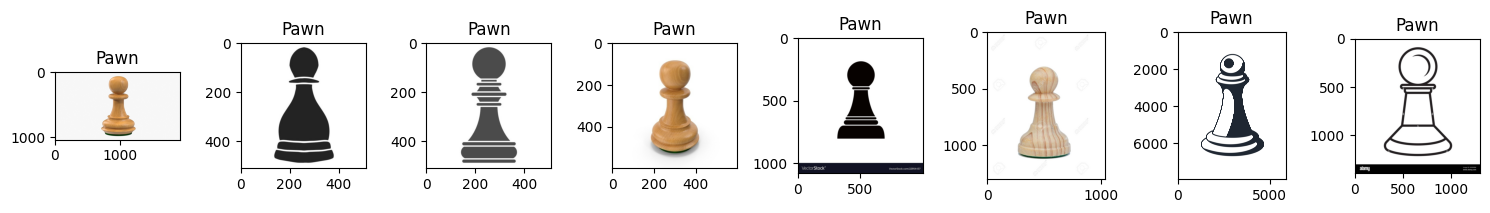

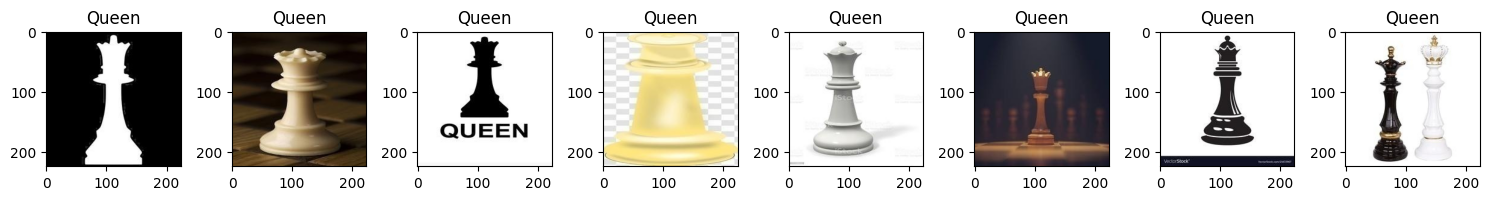

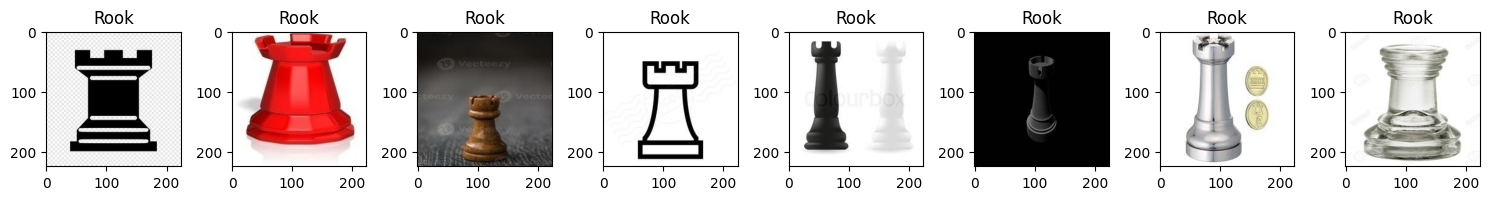

In [27]:
plot_img(dir_list=model.data.dir_list, labels=model.data.labels, image_no=8)

## Seting up the model for training

In [28]:
model.setup_model()

In [29]:

model.train_run()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory ./lightning_logs/7iiyqkq3/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
-

Epoch 11: 100%|██████████| 34/34 [00:06<00:00,  5.22it/s, v_num=qkq3]


## Check the model with validation dataset

In [30]:
model.validation_run()

Restoring states from the checkpoint path at ./lightning_logs/7iiyqkq3/checkpoints/epoch=11-step=408.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/7iiyqkq3/checkpoints/epoch=11-step=408.ckpt
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 28.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.5135135054588318
        val_loss             1.53472101688385
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Check the model with test dataset

In [31]:
model.test_run()

Restoring states from the checkpoint path at ./lightning_logs/7iiyqkq3/checkpoints/epoch=11-step=408.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/7iiyqkq3/checkpoints/epoch=11-step=408.ckpt
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 22.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5675675868988037
        test_loss           1.4868403673171997
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Check the model for final results

In [32]:
model.evaluation()

              precision    recall  f1-score   support

      Bishop     0.4412    0.6977    0.5405        43
        King     0.8400    0.5833    0.6885        36
      Knight     0.6522    0.4286    0.5172        35
        Pawn     0.8462    0.3333    0.4783        33
       Queen     0.4681    0.6471    0.5432        34
        Rook     0.5652    0.6341    0.5977        41

    accuracy                         0.5631       222
   macro avg     0.6355    0.5540    0.5609       222
weighted avg     0.6263    0.5631    0.5626       222



## Loading model based on full load with training or loading the weights only

In [33]:
# model = model.load_model(checkpoint_dir=CHECK_PATH) # only load weights

In [34]:
model = model.load_full(checkpoint_dir=CHECK_PATH)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Restoring states from the checkpoint path at ./lightning_logs/version_1/checkpoints/epoch=5-step=204.ckpt
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:347: The dirpath has changed from './lightning_logs/version_1/checkpoints' to './lightning_logs/version_26/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 168   
1 | 

Epoch 13: 100%|██████████| 34/34 [00:03<00:00, 11.15it/s, v_num=26]
